In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction



def get_qubit_op(coordinates):

    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter):

    backend = BasicAer.get_backend("statevector_simulator")
 
    result = exact_solver(problem,converter)

    optimizer = SLSQP(maxiter=5)

    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=backend) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    #vqe_ground = vqe_result.eigenstate perhaps more accurate? Downside: don't get circuit 
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    return vqe_ground, min_eng

In [3]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
seed = 50

# Option 1: Calucate the force according to Equation 7
def calc_forces(coordinates):
    
    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op([coordinates[0],coordinates[1]])
 
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op, num_part, num_orb, problem, converter)
    psi_0 = CircuitStateFn(psi_0)

    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus_0, num_part_plus_0, num_orb_plus_0, problem_plus_0, converter_plus_0) = get_qubit_op([coordinates[0] + dR,coordinates[1]])
    
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus_0, num_part_minus_0, num_orb_minus_0, problem_minus_0, converter_minus_0) = get_qubit_op([coordinates[0] - dR,coordinates[1]])
    
    rep_eng_plus_0 = problem_plus_0.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus_0 = problem_minus_0.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
    #define desired observable (H_+ - H_-)/(2dR) = force  
    Obs0 = (qubit_op_plus_0-qubit_op_minus_0)
       
    #get the expectation value <psi_0|O|psi_0>¨
    
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1024, seed_transpiler=seed, seed_simulator=seed)
    measurable_expression = StateFn(Obs0, is_measurement=True).compose(psi_0) 
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    f0 = -(sampler.eval().real + rep_eng_plus_0 - rep_eng_minus_0)
    
    
    
    ### repeat same for other atom ###
    (qubit_op_plus_1, num_part_plus_1, num_orb_plus_1, problem_plus_1, converter_plus_1) = get_qubit_op([coordinates[0],coordinates[1]+dR])
    
    (qubit_op_minus_1, num_part_minus_1, num_orb_minus_1, problem_minus_1, converter_minus_1) = get_qubit_op([coordinates[0],coordinates[1]-dR])
    
    rep_eng_plus_1 = problem_plus_1.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus_1 = problem_minus_1.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy

    #define desired observable (H_+ - H_-)/(2dR) = force  
    Obs1 = (qubit_op_plus_1-qubit_op_minus_1)
    
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1024, seed_transpiler=seed, seed_simulator=seed)
    measurable_expression = StateFn(Obs1, is_measurement=True).compose(psi_0) 
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    f1 = -(sampler.eval().real + rep_eng_plus_1 - rep_eng_minus_1)
    
    return f0*Ha*(1/(2*dR*angst)),f1*Ha*(1/(2*dR*angst))

In [4]:
#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10


#mass of particle1 (H)
mass_0 = 1.67e-27
#mass of particle2 (H)
mass_1 = 1.67e-27
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init_0 = 0
v_init_1 = 0

#initial positions of atoms
init_pos = [0,1]

#integrator timesteps
times = np.arange(0*femto, 30.0*femto, dt)
#coordinate array
coords = [init_pos]
force = []

#temperature in ?? 
T = 1

m = 10 #times which we calculate the force
forces = np.zeros((m,2))

for time in times:
    r = coords[-1]
    (f0,f1) = calc_forces(coords[-1])
    force.append(f0)
    forces[0,0] = f0
    forces[0,1] = f1
    
    #calculation of force covariance matrix
    for i in range(1,m):
        (forces[i,0],forces[i,1]) = calc_forces(coords[-1]) 
        
    f0_av = 1/m*np.sum(forces[:,0])
    f1_av = 1/m*np.sum(forces[:,1])
    
    a0 = 1/m*(np.linalg.norm(forces[:,0])**2) - f0_av**2
    a1 = 1/m*(np.linalg.norm(forces[:,1])**2) - f1_av**2
     
    if time == 0:
        v0_next = (1-1/(2*T)*a0*dt)*v_init_0 + dt*f0/mass_0 
        v1_next = (1-1/(2*T)*a1*dt)*v_init_1 + dt*f1/mass_1 
        
        r0_next = r[0]*angst + dt*v_init_0
        r1_next = r[1]*angst + dt*v_init_1
        coords.append([r0_next/angst,r1_next/angst])
    else:
        r_prev = coords[-2]
        r0_next = r[0]*angst + dt*v0_next
        r1_next = r[1]*angst + dt*v1_next
        v0_next = (1-a0*dt)*v0_next + dt*f0/mass_0 
        v1_next = (1-a1*dt)*v1_next + dt*f1/mass_1 

        coords.append([r0_next/angst,r1_next/angst])

/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


a0 = -1.232595164407831e-32
a0 = -1.232595164407831e-32
a0 = 0.0
a0 = -1.232595164407831e-32
a0 = -1.232595164407831e-32
a0 = -4.930380657631324e-32
a0 = 2.465190328815662e-32
a0 = 1.232595164407831e-32
a0 = 0.0
a0 = 6.162975822039155e-33
a0 = 0.0
a0 = 7.703719777548943e-34
a0 = 1.925929944387236e-34
a0 = 0.0
a0 = 1.232595164407831e-32
a0 = 2.465190328815662e-31
a0 = 9.860761315262648e-32
a0 = -1.9721522630525295e-31
a0 = 3.944304526105059e-31
a0 = 1.9721522630525295e-31
a0 = 1.9721522630525295e-31
a0 = 0.0
a0 = -7.395570986446986e-32
a0 = -6.162975822039155e-33
a0 = -3.009265538105056e-36
a0 = 3.0814879110195774e-33
a0 = -1.232595164407831e-32
a0 = 0.0
a0 = 1.232595164407831e-32
a0 = -1.232595164407831e-32
a0 = 3.697785493223493e-32
a0 = 0.0
a0 = 0.0
a0 = 2.465190328815662e-32
a0 = -3.697785493223493e-32
a0 = -2.465190328815662e-32
a0 = 0.0
a0 = 1.232595164407831e-32
a0 = 0.0
a0 = -2.465190328815662e-32
a0 = 0.0
a0 = 0.0
a0 = 0.0
a0 = 2.465190328815662e-32
a0 = 2.465190328815662e-32
a

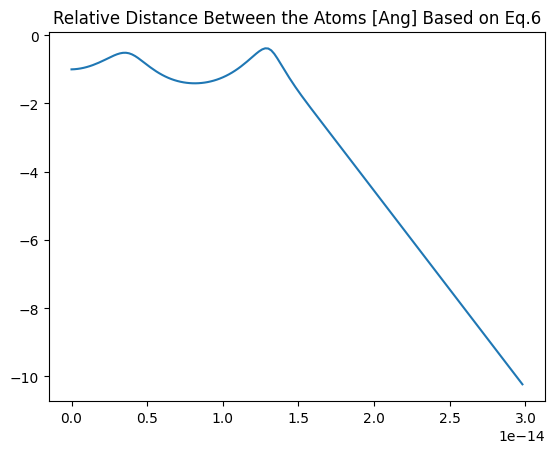

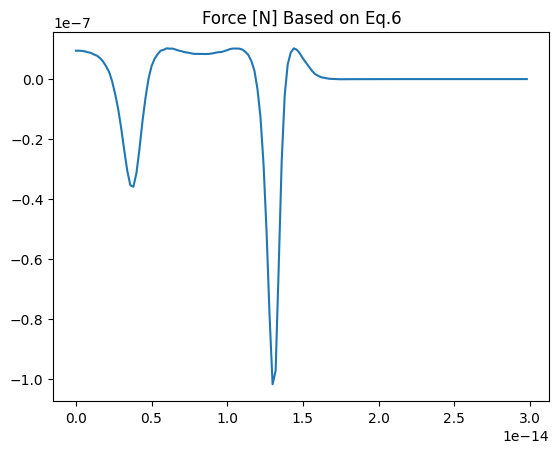

In [5]:
#plot relative distance of molecules as function of time
#Eq.7

coords_np = np.array(coords)
rel_dist = coords_np[1:,0] - coords_np[1:,1]
plt.plot(times,rel_dist)
plt.title('Relative Distance Between the Atoms [Ang] Based on Eq.6')
plt.show()
plt.plot(times,force)
plt.title('Force [N] Based on Eq.6')
plt.show()

In [6]:
def calc_energy(op,num_part,num_orb,problem,converter):
    
    backend = BasicAer.get_backend("statevector_simulator")

    #no clue why this is needed. Without it the initial state has different # of qubits than the number of qubits in qubit operator
    # and we get an error. 
    result = exact_solver(problem,converter)

    optimizer = SLSQP(maxiter=5)

        #result = exact_solver(problem,converter)
        #exact_energies.append(result.total_energies[0].real)
    
    init_state = HartreeFock(num_orb, num_part, converter)
   
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    
    vqe_calc = vqe.compute_minimum_eigenvalue(op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    return vqe_result

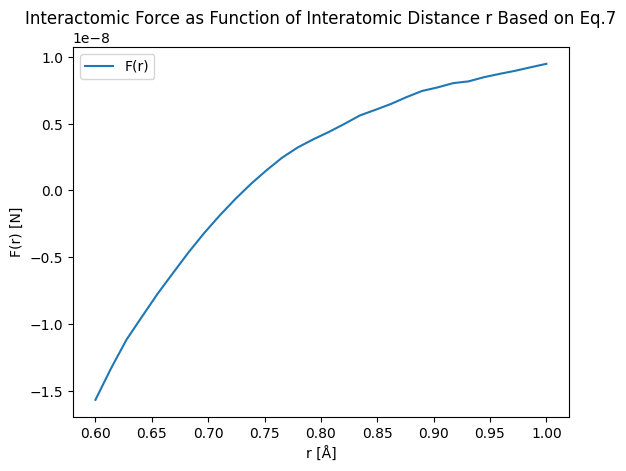

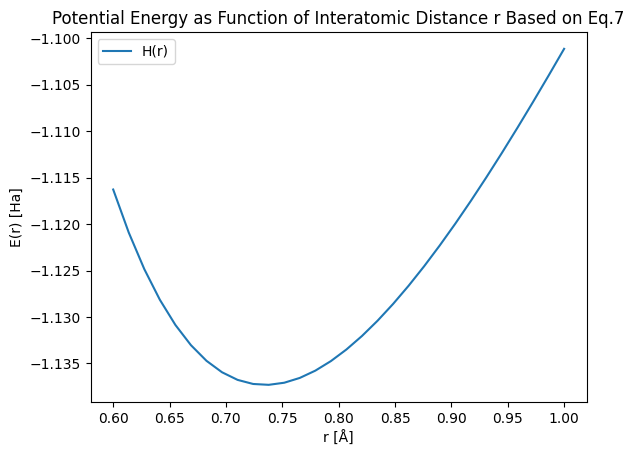

In [7]:
#Eq.7

n = 30 # number of points
r = np.linspace(0.6,1.0,n)
forces = np.zeros(n)
potential = np.zeros(n)

for x in range(n):
    dist = r[x]
    forces[x],_= calc_forces([0,dist])
    op, num_part, num_orb, problem, converter = get_qubit_op([0,dist])
    potential[x]= calc_energy(op,num_part,num_orb,problem,converter)
    
plt.plot(r, forces, label='F(r)')
plt.title('Interactomic Force as Function of Interatomic Distance r Based on Eq.7')
plt.xlabel('r [Å]')
plt.ylabel('F(r) [N]')
plt.legend()
plt.show()

plt.plot(r, potential, label = 'H(r)')

plt.title('Potential Energy as Function of Interatomic Distance r Based on Eq.7')
plt.xlabel('r [Å]')
plt.ylabel('E(r) [Ha]')
plt.legend()
plt.show()
